In [1]:
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from queries import Simbad
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from matplotlib.ticker import MultipleLocator
import pickle
import os

% matplotlib inline
#top_level='/Users/codydirks/PGCC/'
top_level='/DataDisk/datafiles/PGCC_HST/'

def get_r_dist(pgcc,sightline_ra,sightline_dec):
    angle=pgcc['gau_position_angle']
    sin=np.sin(-angle)
    cos=np.cos(-angle)
    a=pgcc['gau_major_axis']/2.
    b=pgcc['gau_minor_axis']/2.
    gal=SkyCoord(ra=sightline_ra*u.degree,dec=sightline_dec*u.degree,frame='icrs').galactic
    del_l=60.*(gal.l.value-pgcc['glon'])
    del_b=60.*(gal.b.value-pgcc['glat'])
    return np.sqrt((((cos*del_l+sin*del_b)/a)**2+((sin*del_l-cos*del_b)/b)**2))

In [2]:
hdulist=fits.open(top_level+'HFI_PCCS_GCC_R2.02.fits')
pgcc_data=hdulist[1].data

In [3]:
p_file='simbad_target_results_v2.p'

In [6]:
simbad_results=[]
i=1
for pgcc in pgcc_data:
    ra=str(pgcc['ra'])
    dec=pgcc['dec']
    rad=str(round(pgcc['gau_major_axis'],3))
    if dec>0.:
        dec='+'+str(dec)
    else:
        dec=str(dec)
    #critstring='region(circle,icrs,J2000,'+ra+' '+dec+','+rad+'m) & Vmag < 10 & cat=\'HD\''
    critstring='region(circle,icrs,J2000,'+ra+' '+dec+','+rad+'m) & Vmag < 11 & sptypes<\'A0\''
    res=Simbad.CritSearch(critstring)
    if len(res)>0:
        simbad_results.append([pgcc,res])
        
    if i%100==0:
        pickle.dump(simbad_results, open(p_file,'wb'))
        clear_output()
        print i, len(simbad_results)
    i=i+1
pickle.dump(simbad_results, open(p_file,'wb'))

13200 1603


In [4]:
simbad_results=pickle.load(open(p_file,'rb'))
print len(simbad_results)

1604


In [5]:
simbad_results.sort(key=lambda x: len(x[1]),reverse=True)
[x for x in simbad_results if 'HD 147196' in [y.identifier for y in x[1]]]

[]

In [6]:
known_pgcc_dist=[x for x in simbad_results if x[0]['dist']>0.0]
print len(known_pgcc_dist)

547


In [7]:
filenames=[top_level+'gaia_data/TgasSource_000-000-0'+'{:02}'.format(i)+'.fits' for i in range(16)]
pgcc_gaia_results=[]
k=1
for res in known_pgcc_dist:
    clear_output()
    print k,
    k=k+1
    gaia_results=[]
    for star in [x for x in res[1] if len(x.identifier.strip('ABHD '))<=6]:
        idlist=Simbad.IDList(star.identifier)
        tyc=[x for x in idlist if x.startswith('TYC')]
        hip=[x for x in idlist if x.startswith('HIP')]
        hip_id=-1
        tyc_id=''
        if len(tyc)>0 or len(hip)>0:
            if len(hip)>0:
                hip_id=int(hip[0].split()[1])
            if len(tyc)>0:
                tyc_id=tyc[0][4:]
            print 'Found',star.identifier,', Searching Gaia data',
            for filename in filenames:
                #print filenames.index(filename),
                hdulist=fits.open(filename)
                scidata=hdulist[1].data
                gaia_dat=scidata[scidata['hip']==hip_id]
                if len(gaia_dat)==0:
                    gaia_dat=scidata[scidata['tycho2_id']==tyc_id]
                if len(gaia_dat)>0:
                    plx=gaia_dat['parallax']
                    plx_err=gaia_dat['parallax_error']
                    star_dist=1000./(plx)
                    star_min_dist=round(1000./(plx+plx_err),3)
                    star_max_dist=round(1000./(plx-plx_err),3)
                    if star_max_dist < 0.0:
                        star_max_dist=2*star_dist
                    if plx > 0.0 and star_min_dist > 1000.*(res[0]['dist']+res[0]['dist_sig']):
                        gaia_results.append([star,gaia_dat])
                    break
                    
    if len(gaia_results)>0:
        pgcc_gaia_results.append([res[0],gaia_results])

 547 Found SK 69 , Searching Gaia data


In [8]:
nearest_results=[]
nearest_threshold=2
for p in pgcc_gaia_results:
    near=[]
    pgcc=p[0]
    angle=pgcc['gau_position_angle']
    sin=np.sin(-angle)
    cos=np.cos(-angle)
    a=pgcc['gau_major_axis']/1.
    b=pgcc['gau_minor_axis']/1.
    for dataset in p[1]:
        r_dist=get_r_dist(pgcc,dataset[0].ra,dataset[0].dec)
        ra=dataset[0].ra
        dec=dataset[0].dec
        gal=SkyCoord(ra=ra*u.degree,dec=dec*u.degree,frame='icrs').galactic
        del_l=60.*(gal.l.value-pgcc['glon'])
        del_b=60.*(gal.b.value-pgcc['glat'])
        if r_dist < nearest_threshold:
            near.append(dataset)
    if len(near)>0:
        nearest_results.append([p[0],near])
        
print len(nearest_results)

51


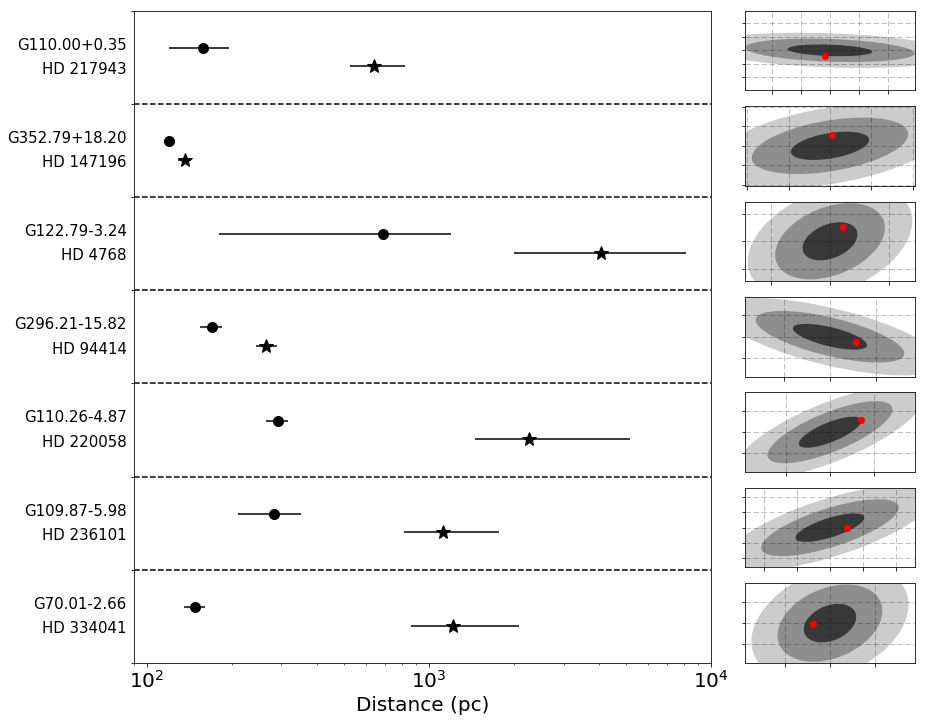

In [14]:
intr_cols={'O9':-0.31,
           'B1':-0.26,
           'B2':-0.24,
           'B3':-0.2,
           'B4':-0.18,
           'B5':-0.16,
           'B6':-0.14,
           'B7':-0.13,
           'B8':-0.11,
           'B9':-0.07,
           'B9.5':-0.04
          }
nearest_results=[x for x in nearest_results if x[1][0][1]['parallax']>0.0]

nearest_results.sort(key=lambda x: x[1][0][0].vmag, reverse=True)
nearest_results.sort(key=lambda x: get_r_dist(x[0],x[1][0][0].ra,x[1][0][0].dec), reverse=True)


selected=['HD 334041',
         'HD 236101',
         'HD 94414',
         'HD 4768',
         'HD 217943',
         'HD 220058',]
order=[0,1,3,4,6,2]

chosen=[x for x in nearest_results if x[1][0][0].identifier in selected]
chosen.sort(key=lambda x: x[1][0][0].vmag,reverse=True)
fig2=plt.figure(2,figsize=(14,2*len(chosen)))
majorLocator=MultipleLocator(5)

G=gridspec.GridSpec(len(chosen)+1,4)
subplt=plt.subplot(G[:,0:3])
subplt.set_yticklabels([])
subplt.set_ylim(0,len(chosen)+1)
subplt.set_xlim(90,10000)
subplt.set_xlabel('Distance (pc)',fontsize=20)
subplt.tick_params(axis='x',labelsize=20)
#subplt.set_xlim(0,700)
subplt.set_xscale('log')
k=0
for result in chosen:
    pgcc=result[0]
    sightline=result[1][0][0]
    k=order[selected.index(sightline.identifier)]
    gaia_data=result[1][0][1]
    plx=gaia_data['parallax']
    plx_err=gaia_data['parallax_error']
    
    pgcc_dist=1000.*result[0]['dist']
    pgcc_min_dist=pgcc_dist-1000.*pgcc['dist_sig']
    pgcc_max_dist=pgcc_dist+1000.*pgcc['dist_sig']
    star_dist=float(1000./(plx))
    star_min_dist=round(1000./(plx+plx_err),3)
    star_max_dist=round(1000./(plx-plx_err),3)
    if star_max_dist < 0.0:
        star_max_dist = 2.*star_dist
    #pgcc_dist=np.log10(pgcc_dist)
    #pgcc_max_dist=np.log10(pgcc_max_dist)
    #pgcc_min_dist=np.log10(pgcc_min_dist)
    #star_dist=np.log10(star_dist)
    #star_max_dist=np.log10(star_max_dist)
    #star_min_dist=np.log10(star_min_dist)

    if star_min_dist>pgcc_max_dist:
        col='k'
    elif star_max_dist < pgcc_min_dist:
        col='k'
    else:
        col='k'
    subplt.errorbar(star_dist,k+0.4,xerr=[[star_dist-star_min_dist],[star_max_dist-star_dist]],fmt='*',color=col,ms=15)
    subplt.errorbar(pgcc_dist,k+0.6,xerr=[[pgcc_dist-pgcc_min_dist],[pgcc_max_dist-pgcc_dist]],fmt='o',color=col,ms=10)
    subplt.text(85,k+0.55,pgcc['name'].split()[1],ha='right',va='bottom',fontsize=15)
    subplt.text(85,k+0.45,sightline.identifier,ha='right',va='top',fontsize=15)
    
    
    #sp=Simbad.SpType(sightline.identifier)
    #subplt.text(2,k+0.35,sp+' , '+str(sightline.vmag),ha='right')
    #if sp.startswith('B9.5'):
    #    subplt.text(2,k+0.2, 'E(B-V)='+str((sightline.bmag-sightline.vmag)-(intr_cols[sp[0:4]])),ha='right')
    #else:
    #    subplt.text(2,k+0.2, 'E(B-V)='+str((sightline.bmag-sightline.vmag)-(intr_cols[sp[0:2]])),ha='right')
    
    subplt1=plt.subplot(G[len(chosen)-k,3])
    k=k+1
    
    subplt1.set_xlim(-1.*pgcc['gau_major_axis'],1.*pgcc['gau_major_axis'])
    subplt1.set_ylim(-1.*pgcc['gau_major_axis'],1.*pgcc['gau_major_axis'])
    subplt1.set_xticklabels([])
    subplt1.set_yticklabels([])
    subplt1.xaxis.set_major_locator(majorLocator)
    subplt1.yaxis.set_major_locator(majorLocator)
    subplt1.grid(linestyle='--',color='k',alpha=0.3)
    for i in range(1,4):
        ell=Ellipse(xy=(0,0),width=i*pgcc['gau_major_axis'],
                    height=i*pgcc['gau_minor_axis'],angle=-(180./np.pi)*pgcc['gau_position_angle'])
        ell.set_facecolor('k')
        ell.set_alpha(0.6/i)
        subplt1.add_patch(ell)
    
    angle=pgcc['gau_position_angle']
    sin=np.sin(-angle)
    cos=np.cos(-angle)
    a=pgcc['gau_major_axis']/2.
    b=pgcc['gau_minor_axis']/2.
    
    for dataset in result[1][0:1]:
        ra=dataset[0].ra
        dec=dataset[0].dec
        gal=SkyCoord(ra=ra*u.degree,dec=dec*u.degree,frame='icrs').galactic
        del_l=60.*(gal.l.value-pgcc['glon'])
        del_b=60.*(gal.b.value-pgcc['glat'])
        #if (((cos*del_l+sin*del_b)/a)**2+((sin*del_l-cos*del_b)/b)**2)<=1.:
        subplt1.plot(del_l,del_b,'ro')
        #subplt1.text(1.1,0.9-0.1*result[1].index(dataset),get_r_dist(pgcc,ra,dec),transform=subplt1.transAxes)
        
        
for i in range(6):
    subplt.axhline(i+1,0,1,linestyle='--',color='k')
        
k=5
# Add the one IUE sightline to complete the figure
pgcc_dist=119.999997318
pgcc_min_dist=114.99999743
pgcc_max_dist=124.999997206
star_dist=136.370668996
star_min_dist=129.398
star_max_dist=144.138

subplt.errorbar(star_dist,k+0.4,xerr=[[star_dist-star_min_dist],[star_max_dist-star_dist]],fmt='*',color=col,ms=15)
subplt.errorbar(pgcc_dist,k+0.6,xerr=[[pgcc_dist-pgcc_min_dist],[pgcc_max_dist-pgcc_dist]],fmt='o',color=col,ms=10)
subplt.text(85,k+0.45,'HD 147196',ha='right',va='top',fontsize=15)
subplt.text(85,k+0.55,'G352.79+18.20',ha='right',va='bottom',fontsize=15)

gau_maj=10.2489
gau_min=6.09583
ang=-0.502768
subplt1=plt.subplot(G[1,3])
subplt1.set_xlim(-1.*gau_maj,1.*gau_maj)
subplt1.set_ylim(-1.*gau_maj,1.*gau_maj)
subplt1.set_xticklabels([])
subplt1.set_yticklabels([])
subplt1.xaxis.set_major_locator(majorLocator)
subplt1.yaxis.set_major_locator(majorLocator)
subplt1.grid(linestyle='--',color='k',alpha=0.3)
for i in range(1,4):
        ell=Ellipse(xy=(0,0),width=i*gau_maj,
                    height=i*gau_min,angle=-(180./np.pi)*ang)
        ell.set_facecolor('k')
        ell.set_alpha(0.6/i)
        subplt1.add_patch(ell)        

del_l=0.274910356877 
del_b=2.75093405062
subplt1.plot(del_l,del_b,'ro')  
plt.savefig('/DataDisk/Dropbox/HSTProposal/Cycle25/PGCC/cycle25_sightlines.pdf')

In [15]:
for c in chosen:
    print c[1][0][0]

HD 334041
HD 236101
HD 220058
HD 94414
HD 4768
HD 217943
